# Cluster analysis

Working with unlabeled data

Finde the best number of clusters with **k_means** and **agglomerative clustering**.

In [68]:
# Imports

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
from mpl_toolkits import mplot3d

random_state = 42

## 1. Load the data

In [69]:
# Load the content
df0 = pd.read_csv('Wholesale customers data.csv')

# and check the shape
df0.shape

(440, 8)

In [70]:
# Plot the content
df0.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


## 2. Observe the data distributions

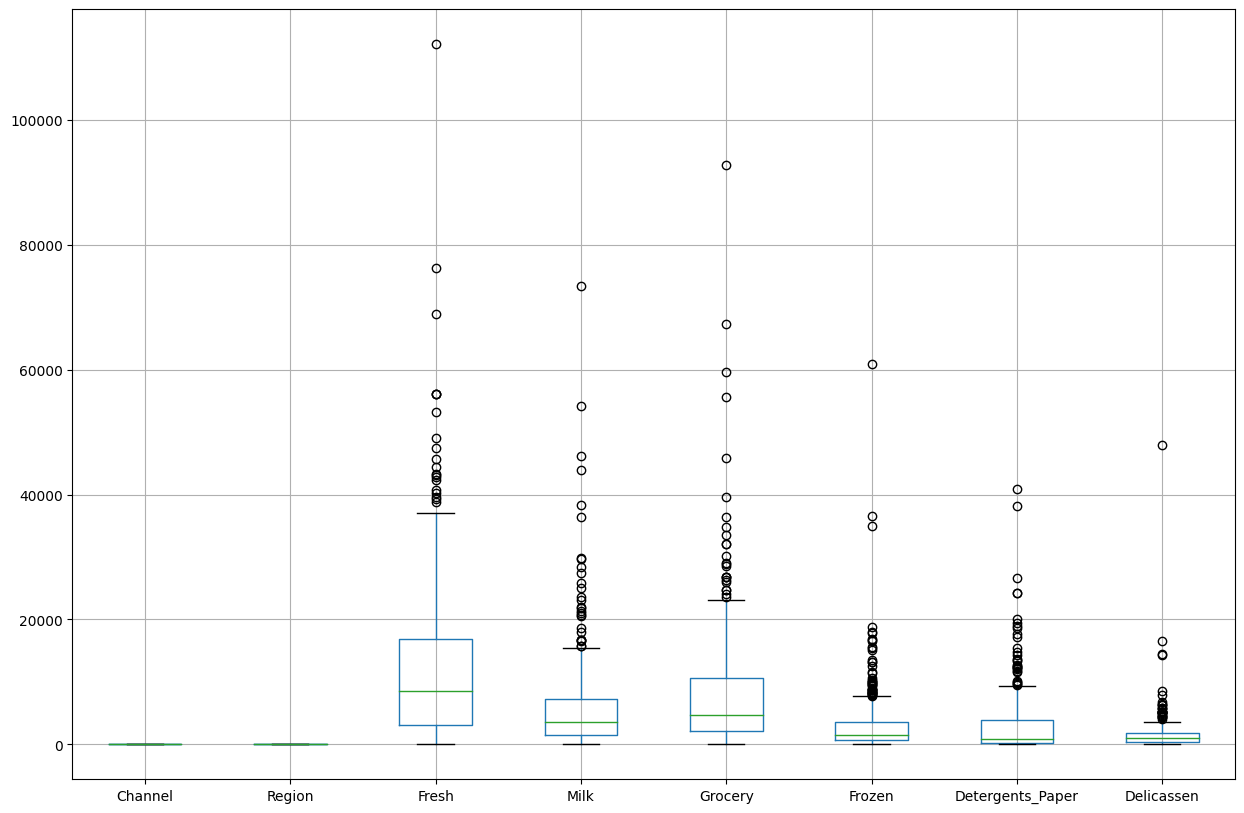

In [71]:
# Boxplot
df0.boxplot(figsize=(15,10));

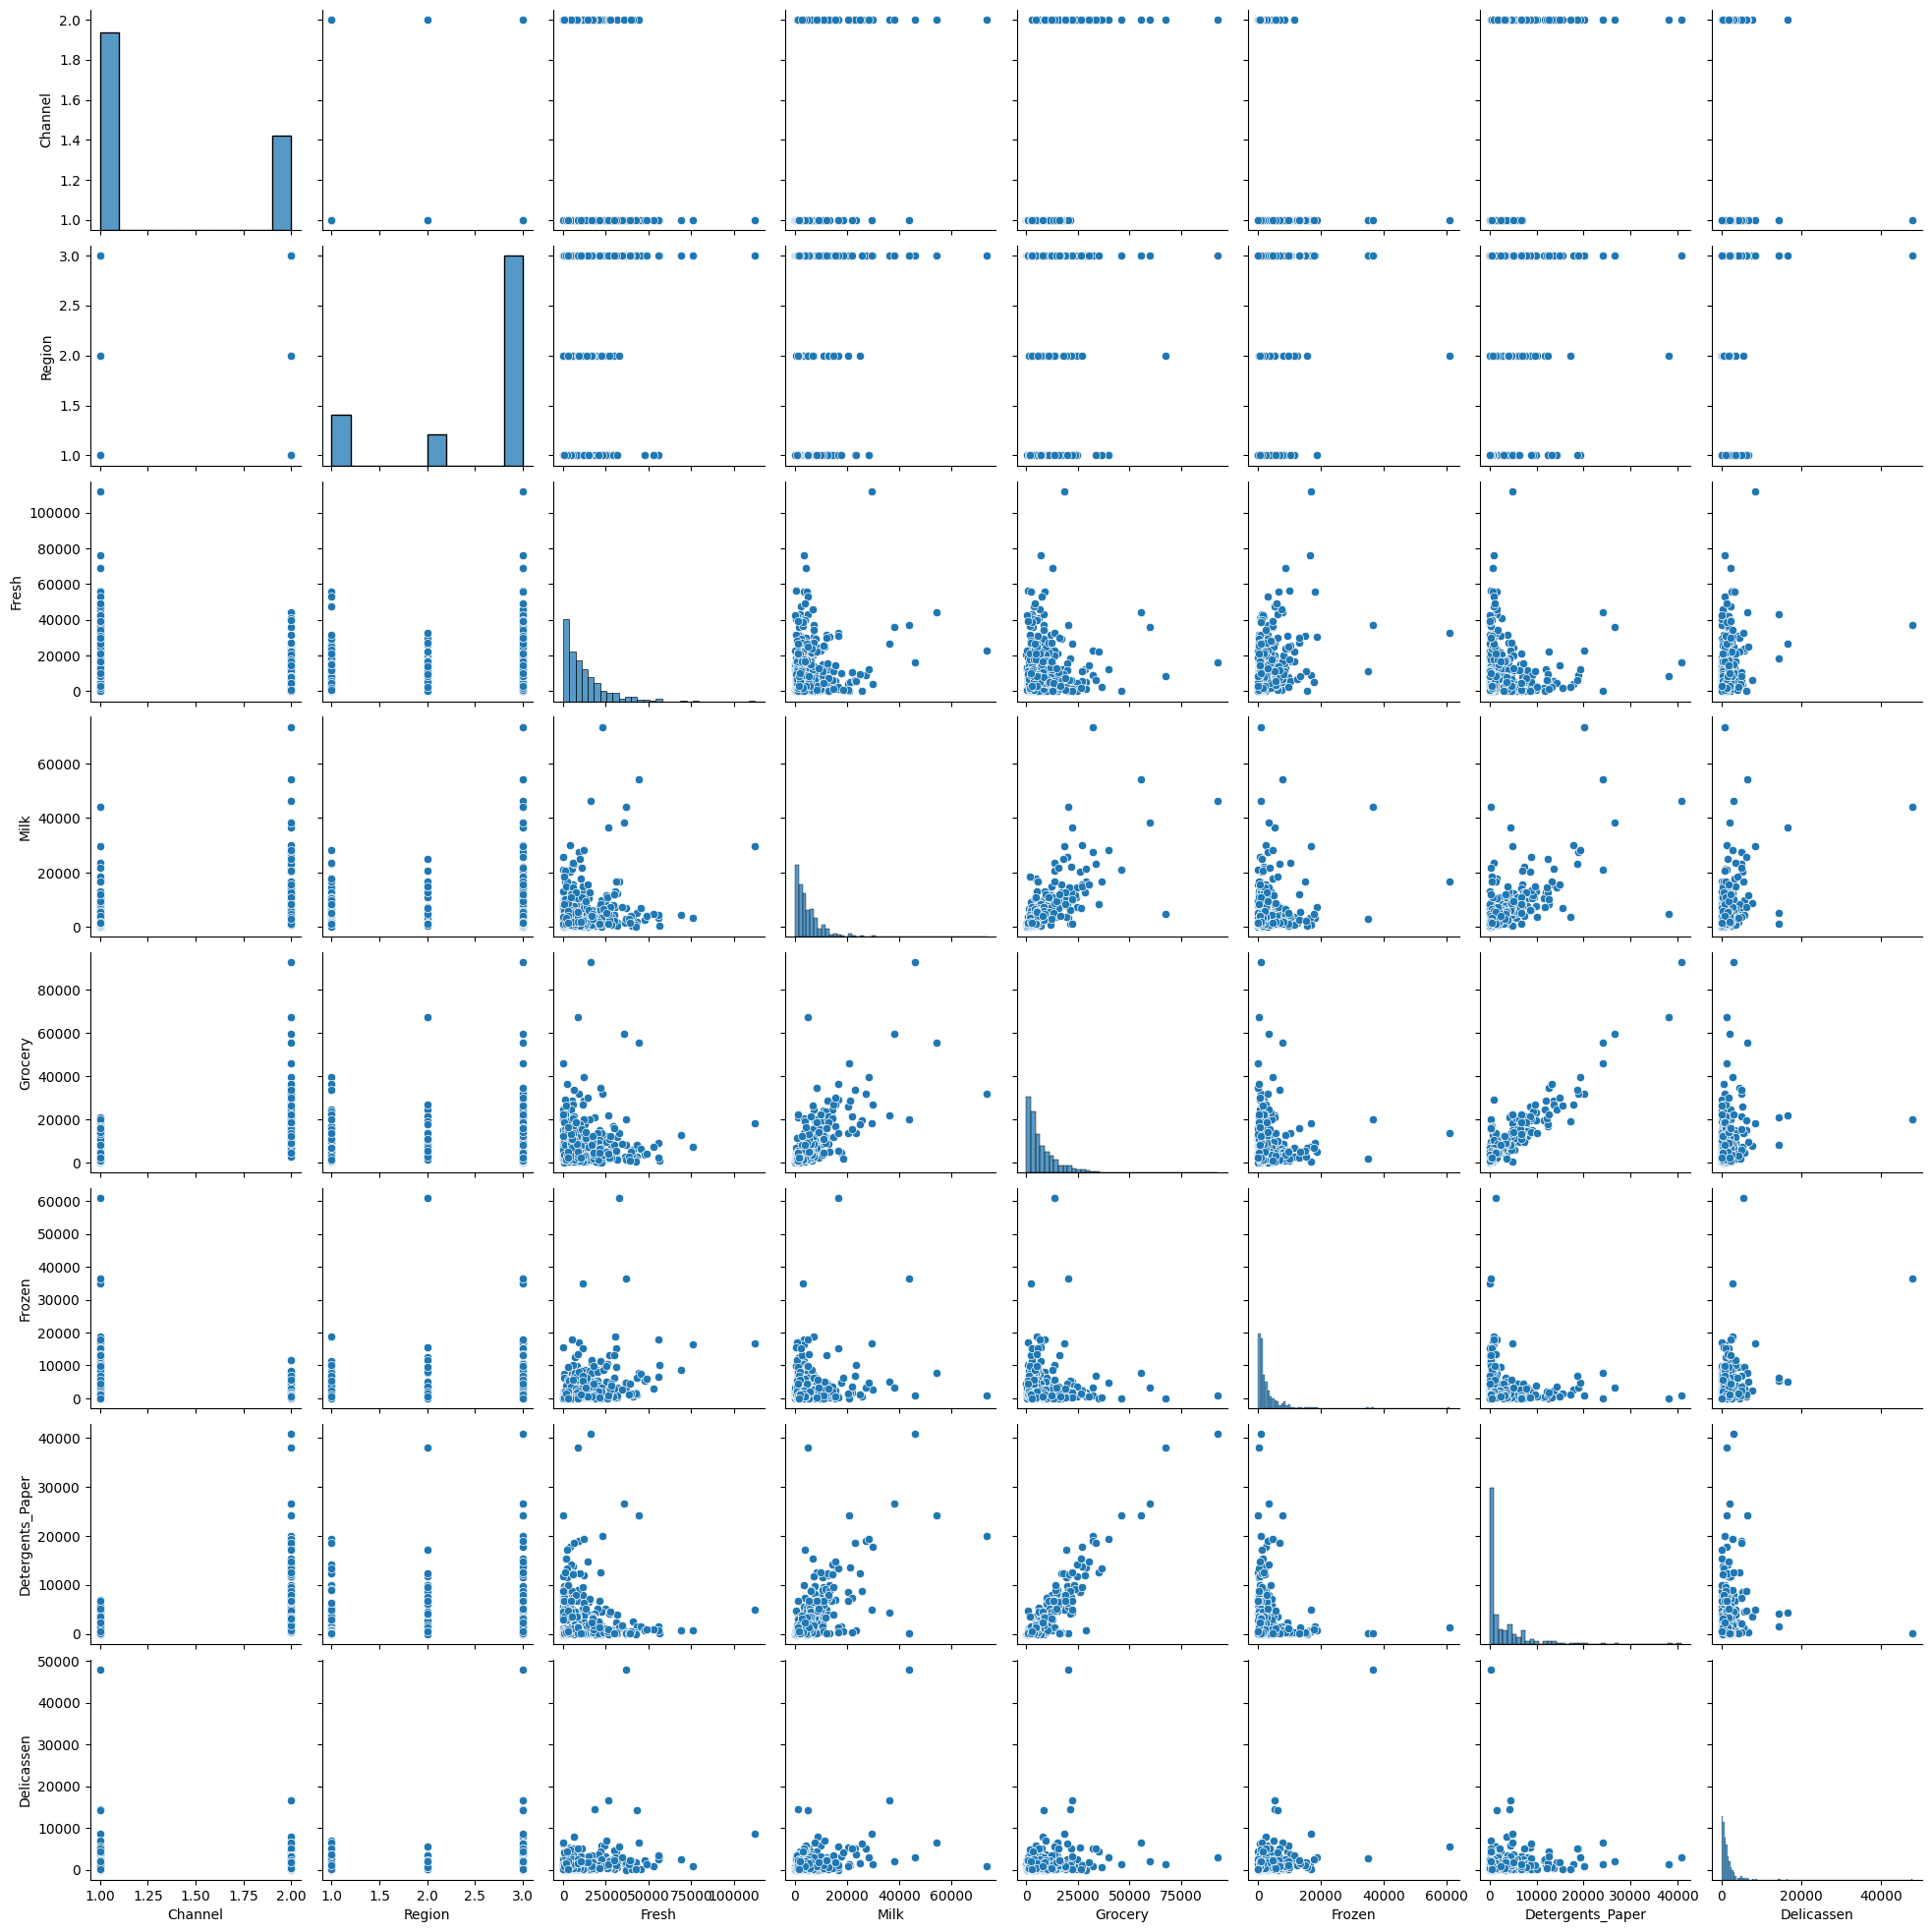

In [72]:
# Pairplot
sns.pairplot(df0);
plt.show()

We can make some observations.

The distributions of values are definitely *skewed* and, in the columns from Fresh to Delicassen, the values are highly concentrated on the right, though, the outliers are frequent, in a very large range.

Since **clustering** is much more effective in absence of oputliers and with all the variables distributed in similar ranges, we need to operate a few transformations.

In [73]:
# Transform all the variables from the column Fresh to Delicassen 
# computing the square root 
df = np.sqrt(df0)

# Remap on the 0:1 range 
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df = pd.DataFrame(scaler.fit_transform(df), columns = df0.columns)
df.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,1.0,1.0,0.332649,0.344530,0.281385,0.039835,0.249488,0.160416
1,1.0,1.0,0.246952,0.347490,0.317250,0.152973,0.277812,0.186029
2,1.0,1.0,0.234044,0.327791,0.283711,0.182200,0.287352,0.399740
3,0.0,1.0,0.340505,0.103027,0.208796,0.310384,0.103755,0.186684
4,1.0,1.0,0.446188,0.250813,0.274408,0.238171,0.201784,0.323509


Results of the transformations:

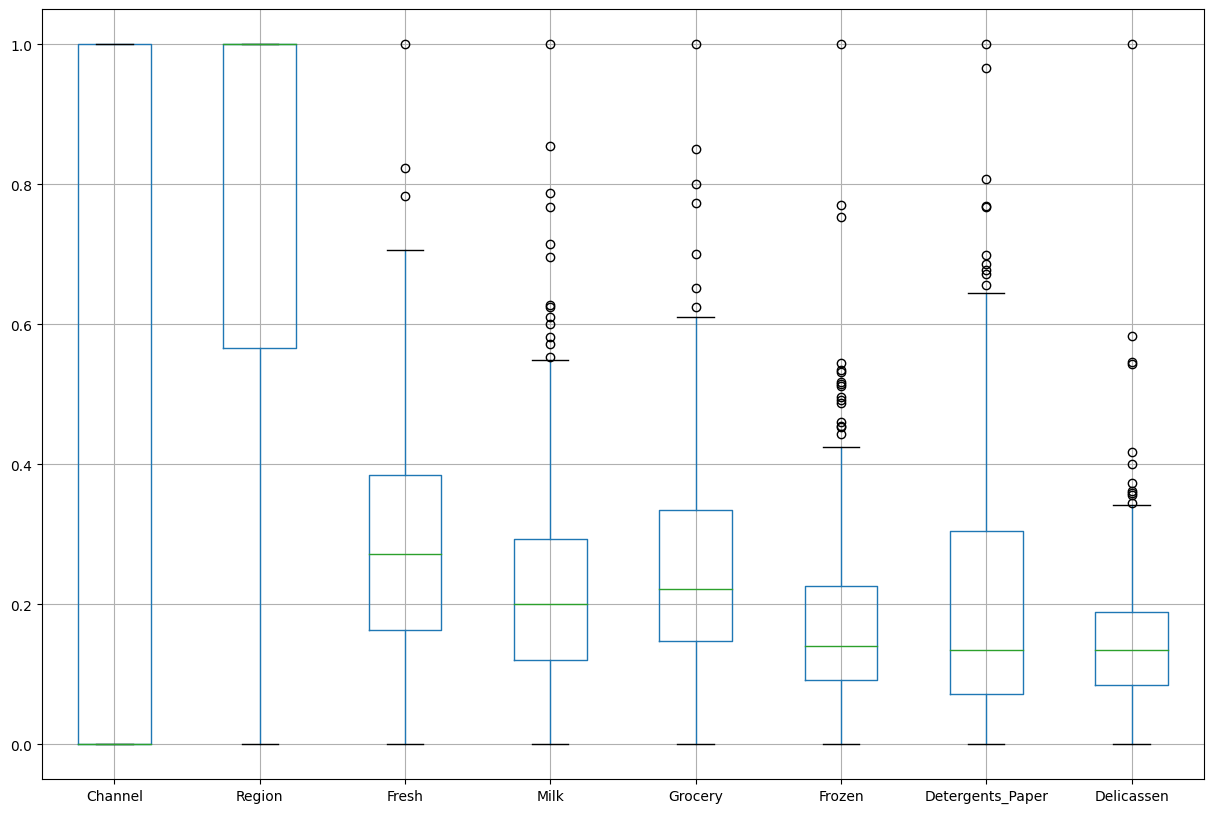

In [74]:
# Boxplot
df.boxplot(figsize=(15,10));

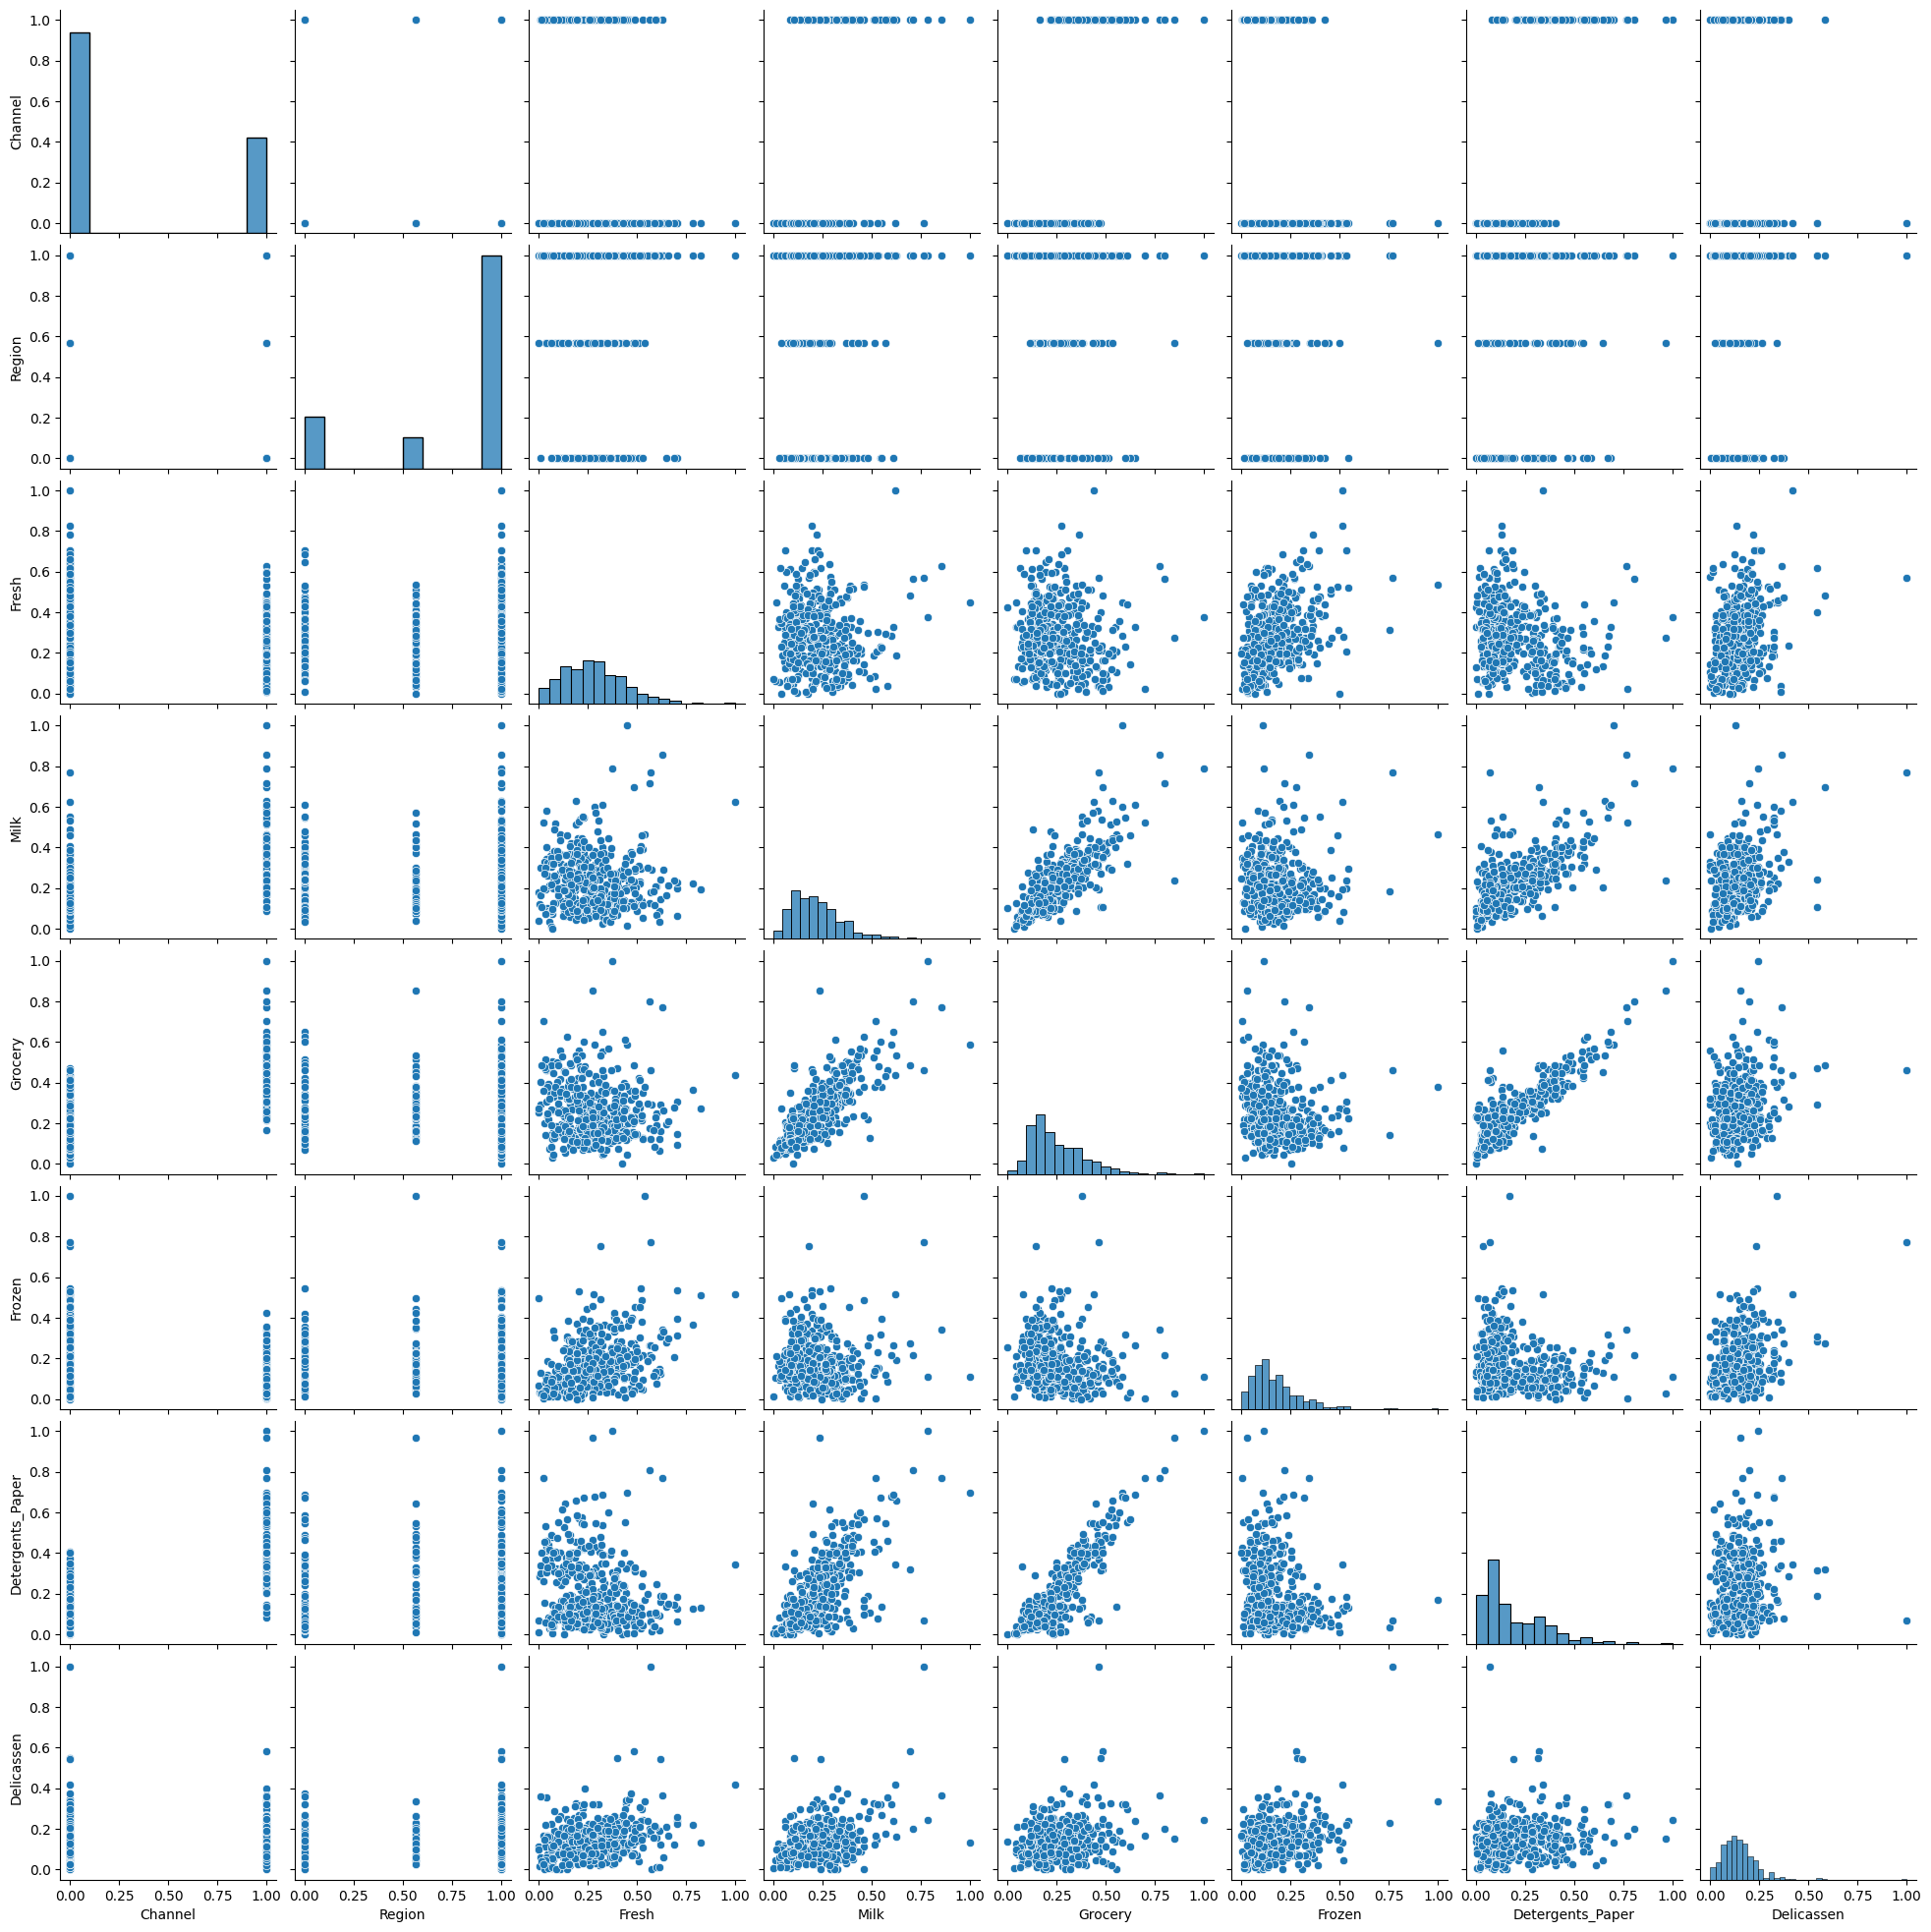

In [75]:
# Pairplot
sns.pairplot(df);

At this point, we can see that the effect of the outliers is reduced. Hence, we can now compute the clustering.

## 3. Elbow method, to find the optimal number of clusters

Test `KMeans` with varying number of clusters, from 2 to 10. 

In [76]:
from sklearn.model_selection import ParameterGrid
import warnings
warnings.filterwarnings("ignore")

k_range = list(range(2,11)) # Set the range of k values to test 
parameters_km = [{'n_clusters': k_range}]
pg = list(ParameterGrid(parameters_km))
inertias = []
silhouettes = []
for k in range(len(pg)):
  est = KMeans(**(pg[k]), random_state = random_state)
  pred_KMeans = est.fit_predict(df)
  inertias.append(est.inertia_)
  silhouettes.append(silhouette_score(df, pred_KMeans))

In [77]:
# Show inertias
inertias

[99.86307689796257,
 57.21491538223245,
 43.31694564244872,
 38.03114098574737,
 33.59435731793821,
 29.82833512637434,
 27.078734594965823,
 25.01480261548245,
 23.377045149946543]

In [78]:
# and silhouettes
silhouettes

[0.5392986150629352,
 0.5795485110952061,
 0.5689409837703107,
 0.3794412823215123,
 0.40984355521101656,
 0.3744134070306997,
 0.3677534489516345,
 0.3227086950316374,
 0.28853553020103384]

## 4. Plot **inertia** and **silhouette score** versus *k*

In [79]:
def two_plots(x, y1, y2, xlabel, y1label, y2label):
    fig, ax1 = plt.subplots()

    color = 'tab:red'
    ax1.set_xlabel(xlabel)
    ax1.set_ylabel(y1label, color=color)
    ax1.plot(x, y1, color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:blue'
    ax2.set_ylabel(y2label, color=color)  # we already handled the x-label with ax1
    ax2.plot(x, y2, color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.set_ylim(0,1) # the axis for silhouette is [0,1]

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()

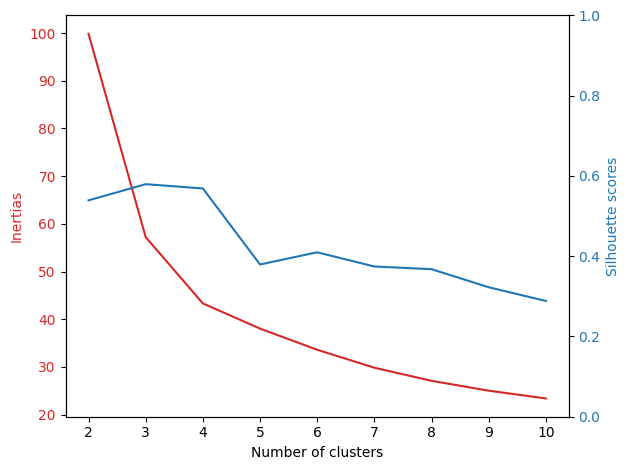

In [80]:
two_plots(x=k_range, y1=inertias, y2=silhouettes
          , xlabel='Number of clusters', y1label='Inertias', y2label='Silhouette scores'
         )

An **elbow plot** shows at what value of k the distance between the mean of a cluster and the other data points in the cluster is at its lowest.

Two values are of importance here — *distortion* and *inertia*. Distortion is the average of the euclidean squared distance from the centroid of the respective clusters. Inertia is the sum of squared distances of samples to their closest cluster centre.

Remember we care about intra-cluster similarity in K-means and this is what an elbow plot helps to capture.

## 5. Cluster with the optimal number of k


The two *elbow* points of inertia would suggest as cluster number 3 or 4, slightly more pronounced in 3. Silhouette has a maximum on 4, but the increase with respect to 3 is very small.

We will choose k=3

In [81]:
k = 3
km = KMeans(n_clusters = k, random_state = random_state)
y_km = km.fit_predict(df)
print("Number of clusters = {}\t- Distortion = {:6.2f}\t- Silhouette score = {:4.2f}"\
    .format(k,inertias[k_range.index(k)],silhouettes[k_range.index(k)]))

Number of clusters = 3	- Distortion =  57.21	- Silhouette score = 0.58


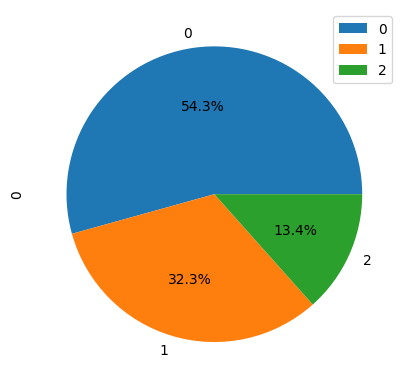

In [82]:
clust_sizes_km = np.unique(y_km,return_counts=True)
pd.DataFrame(clust_sizes_km[1]).plot.pie(y=0, autopct='%1.1f%%', );
plt.show()

### Comments
The __silhouette score__ ranges from `-1` (worst) to `1` (best); as a rule of thumb, a value greater than `0.5` should be considered acceptable.

# Hierarchical Agglomerative Clustering

We will try a grid of parameter configurations, with the number of clusters in the range `2:10` and the four linkage methods available in the *sklearn* implementation of *AgglomerativeClustering*. 

In [83]:
from sklearn.cluster import AgglomerativeClustering
parameters = [{'n_clusters': k_range
                    , 'linkage' : ['ward', 'complete', 'average', 'single']}]
pg = list(ParameterGrid(parameters))
result_ac = []
for i in range(len(pg)):
    ac = AgglomerativeClustering(**(pg[i]))
    y_ac = ac.fit_predict(df)
    result_ac.append([pg[i]['linkage'],pg[i]['n_clusters'],silhouette_score(df,y_ac)])

In [84]:
df_result_ac = pd.DataFrame(data = result_ac, columns=['linkage','n_clusters','silhouette_score'])
df_result_ac.sort_values(by='silhouette_score', ascending=False).head(5)

,linkage,n_clusters,silhouette_score
21,average,5,0.592838
31,single,6,0.583813
22,average,6,0.582406
1,ward,3,0.579549
32,single,7,0.575787


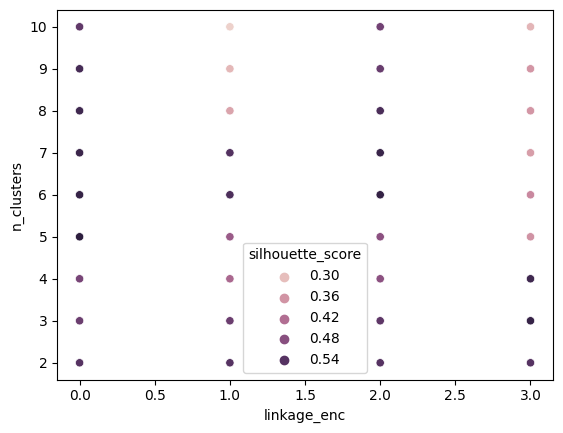

In [85]:
from sklearn.preprocessing import OrdinalEncoder
oe = OrdinalEncoder()
df_result_ac['linkage_enc'] = oe.fit_transform(df_result_ac['linkage'].values.reshape(-1,1))
sns.scatterplot(data=df_result_ac, x='linkage_enc',y='n_clusters', hue='silhouette_score');

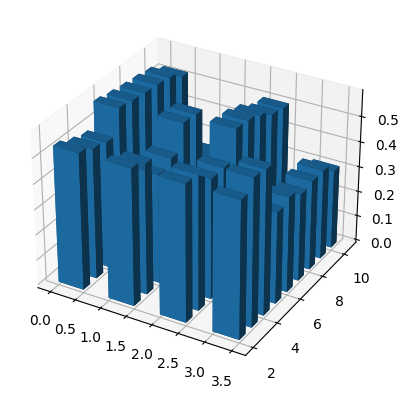

In [86]:
import matplotlib.pyplot as plt 
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from mpl_toolkits import mplot3d
%matplotlib inline 

fig = plt.figure()
ax = plt.axes(projection='3d')

# x, y = np.meshgrid(np.arange(0,len(data[0]),1) + 0.25, 
#     np.arange(0,len(data[:,0]),1) + + 0.25)

x,y = df_result_ac['linkage_enc'].values,df_result_ac['n_clusters'].values
bottom = np.zeros(df_result_ac.shape[0])


width = .5 * np.ones(df_result_ac.shape[0]) #np.ones_like(zpos)
depth = .5 * np.ones(df_result_ac.shape[0])

ax.bar3d(x,y
         ,bottom,width,depth
         ,df_result_ac['silhouette_score'].values
         )
plt.show()

The top five results have a very similar silhouette score, we will choose the setting with 3 clusters, as for k-means, and the linkage giving the best result with 3 clustes, that is `ward`. This is the result record with `index 1` (the record index is the unnamed column at the very left of the dataframe output).

In [87]:
print(df_result_ac.iloc[[1]])

  linkage  n_clusters  silhouette_score  linkage_enc
1    ward           3          0.579549          3.0


In [88]:
ac = AgglomerativeClustering(**(pg[1]))
y_ac = ac.fit_predict(df)

Show the distribution of data in the three clusters

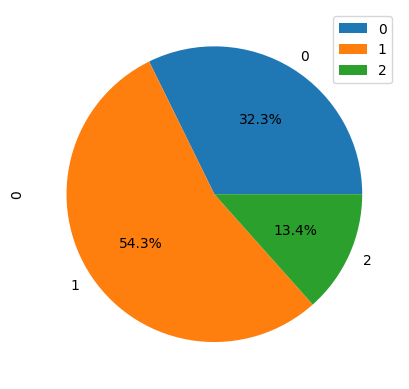

In [89]:
clust_sizes_ac = np.unique(y_ac,return_counts=True)
pd.DataFrame(clust_sizes_ac[1]).plot.pie(y=0, autopct='%1.1f%%', );
plt.show()

# Comments

The solution with the Agglomerative Clustering in this case provides a result very similar to that of kmeans.

It is interesting to compare more deeply the results of the two clustering models. 

The function `pair_confusion_matrix` computes the number of pairs of objects that are in the same clusters or in different clusters in two different clustering schemes. 

The result is given in a 2x2 matrix, the perfect match is when only the numbers in the main diagonal are non zero.

We present here the results normalized to 1:

In [90]:
from sklearn.metrics import pair_confusion_matrix
pcm = pair_confusion_matrix(y_km,y_ac)
pcm / pcm.sum()

array([[0.58414786, 0.        ],
       [0.        , 0.41585214]])

In [91]:
print("The percentage of match between the two clustering schemes is {:6.2f}%"\
    .format((pcm / pcm.sum()).diagonal().sum()*100))

The percentage of match between the two clustering schemes is 100.00%
